# Homework 2 - Logistic Regression
## CSCI 5622 - Spring 2019
***
**Name**: Mohamed Al-Rasbi
***

This assignment is due on Canvas by **11.59 PM on Tuesday, February 12th**. Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your classmates and instructors, but **you must write all code and solutions on your own**, and list any people or sources consulted.

## Overview 
***

Your task for this homework is to build a logistic regression model that implements stochastic gradient ascent. To start, you'll apply it to the task of determining whether a number is 8 or 9

We start by importing and plotting the given data

In [19]:
import numpy as np
import matplotlib.pylab as plt
import math
import pickle, gzip       
from sklearn.utils import shuffle
import time
from prettytable import PrettyTable #pip install PrettyTable
%matplotlib inline 

###### [ 50 points] Problem 1: Implementing the Logistic Regression Classifier
***

In [2]:
class Numbers:
    """
    Class to store MNIST data for images of 9 and 8 only
    """ 
    def __init__(self, location):
        # You shouldn't have to modify this class, but you can if you'd like
        # Load the dataset
        with gzip.open(location, 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f)
                
        self.train_x, self.train_y = train_set
        train_indices = np.where(self.train_y > 7)
        self.train_x, self.train_y = self.train_x[train_indices], self.train_y[train_indices]
        self.train_y = self.train_y - 8
 
        self.valid_x, self.valid_y = valid_set
        valid_indices = np.where(self.valid_y > 7)
        self.valid_x, self.valid_y = self.valid_x[valid_indices], self.valid_y[valid_indices]
        self.valid_y = self.valid_y - 8

In this homework you'll implement a Logistic Regression classifier to take drawings of either an eight or a nine and output the corresponding label.
1.1 - Finish the `calculate_score` function to return the output of applying the dot product of the weights with the input parameter

1.2 - Finish the `sigmoid` function to return the output of applying the sigmoid function to the calculated score

1.3 - Finish the `compute_gradient` function to return the derivate of the cost w.r.t. the weights

1.4 - Finish the `sgd_update` function so that it performs stochastic gradient descent on the single training example and updates the weight vector correspondingly

1.5 - Finish the `mini_batch_update` function so that it performs mini-batch gradient descent on the batches of the training data set example and updates the weight vector correspondingly

In [22]:
from collections import defaultdict
class LogReg:
    
    def __init__(self, X, y, eta = 0.1):
        """
        Create a logistic regression classifier
        :param num_features: The number of features (including bias)
        :param eta: Learning rate (the default is a constant value)
        :method: This should be the name of the method (sgd_update or mini_batch_descent)
        :batch_size: optional argument that is needed only in the case of mini_batch_descent
        """
        self.X = X
        self.y = y
        self.w = np.zeros(X.shape[1]) # can remove from here and ask to be defined in the function
        self.eta = eta
        
    def calculate_score(self, x):
        """
        :param x: This can be a single training example or it could be n training examples
        :return score: Calculate the score that you will plug into the logistic function
        """
#         print(len(x), len(w))
        if x.ndim == 1:
            score = 0
            for i in range(len(x)):
                score += float(self.w[i]*x[i])
            return score
        
        score = []
        for example in x:
            temp = 0
            for i in range(len(example)):
                temp += float(self.w[i]*example[i])
            score.append(temp)
        
        return score
    
    def sigmoid(self, score):
        """
        :param score: Either a real valued number or a vector to convert into a number between 0 and 1
        :return sigmoid: Calcuate the output of applying the sigmoid function to the score. This could be a single
        value or a vector depending on the input
        """
        if type(score) == float:
            return 1 / (1 + math.exp(-score))
        
        output = []
        for i in score:
            try:
                output.append(1 / (1 + math.exp(-i)))
            except OverflowError:
                output.append(1.0)
        
        return output
        
        
    def compute_gradient(self, x, h, y):
        """
        :param x: Feature vector
        :param h: predicted class label
        :param y: real class label
        :return gradient: Return the derivate of the cost w.r.t to the weights
        """
        if type(x) == float:
            return x*(h - y)
        
        return np.dot(x, (h-y))
        
     
    def sgd_update(self):
        """
        Compute a stochastic gradient update over the entire dataset to improve the log likelihood.
        :param x_i: The features of the example to take the gradient with respect to
        :param y: The target output of the example to take the gradient with respect to
        :return: Return the new value of the regression coefficients
        """ 
        for i in range(self.X.shape[0]):
            h = self.sigmoid(self.calculate_score(self.X[i]))
            for j in range(len(self.X[i])):
                gradient = self.compute_gradient(self.X[i][j], h, self.y[i])
                self.w[j] = self.w[j] - (self.eta * gradient)
        
        return self.w
            
    
    def mini_batch_update(self, batch_size):
        """
        One iteration of the mini-batch update over the entire dataset (one sweep of the dataset).
        :param X: NumPy array of features (size : no of examples X features)
        :param y: Numpy array of class labels (size : no of examples X 1)
        :param batch_size: size of the batch for gradient update
        :returns w: Coefficients of the classifier (after updating)
        """
        # TODO: Performing mini-batch training follows the same steps as in stochastic gradient descent,
        # the only major difference is that we’ll use batches of training examples instead of one. 
        # Here we decide a batch size, which is the number of examples that will be fed into the 
        # computational graph at once.
        self.X, self.y = shuffle(self.X, self.y)
        for i in range(0, self.X.shape[0], batch_size):
            h = self.sigmoid(self.calculate_score(self.X[i:i+batch_size]))
            for j in range(len(self.X[i])):
                gradient = self.compute_gradient(self.X[i:i+batch_size,j], h, self.y[i:i+batch_size])
                self.w[j] = self.w[j] - (self.eta * gradient)
        
        return self.w
    
    def progress(self, test_x, test_y, update_method, *batch_size):
        """
        Given a set of examples, computes the probability and accuracy
        :param test_x: The features of the test dataset to score
        :param test_y: The features of the test 
        :param update_method: The update method to be used, either 'sgd_update' or 'mini_batch_update'
        :param batch_size: Optional arguement to be given only in case of mini_batch_update
        :return: A tuple of (log probability, accuracy)
        """
        # TODO: Complete this function to compute the predicted value for an example based on the logistic value
        # and return the log probability and the accuracy of those predictions
        weights = None
        if update_method == 'sgd_update':
            weights = self.sgd_update()
            
        elif update_method == 'mini_batch_update':
            weights = self.mini_batch_update(batch_size[0])
        
        if type(weights) != np.ndarray:
            raise Exception("check passed update_method")
        

        responses = self.sigmoid(self.calculate_score(test_x))
        if type(responses) != list:
            responses = np.array(responses)
        
        hits = 0
        log_prob = 0
        for i in range(len(responses)):
            if np.around(responses[i]) == test_y[i]:
                hits += 1
                log_prob += math.log(responses[i])
            else:
                try:
                    log_prob += math.log(1 - responses[i])
                except ValueError:
                    pass

        accuracy = hits/len(test_y)
        
        return (log_prob, accuracy)
    
    def train(self, x_data, y_data, epoch, update_method, *batch_size):
        '''
        epoch: max number of epochs
        update_method: either 'sgd_update' or 'mini_batch_update'
        Return: dict with epoch number as key and accuracy as value
        '''
        accuracy = {}
        for i in range(1, epoch+1):
            log_prob, acc = self.progress(x_data, y_data, update_method, *batch_size)
            x_data, y_data = shuffle(x_data, y_data)
            accuracy[i] = acc
        
        return accuracy


In [4]:
import unittest

class LogRegTester(unittest.TestCase):
    def setUp(self):
        self.X = np.array([[0.1, 0.3 ], [0.4, 0.6], [0.8, 0.1], [0.8, 0.1], [0.5, 0.8]])
        self.y = np.array([0,  0, 1, 1,  0])
        self.log_reg_classifier_1 = LogReg(self.X, self.y, 0.5)
        self.log_reg_classifier_2 = LogReg(self.X, self.y, 0.5)
        
    def test_sgd_update(self):
        """
        Test sgd_update function from LogReg
        """
        weights = self.log_reg_classifier_1.sgd_update()
        self.assertEqual(round(weights[0], 2), 0.16)
        self.assertEqual(round(weights[1], 2), -0.37)
        
    def tests_mini_batch_update(self):
        """
        Test mini_batch_update function from LogReg
        """
        weights = self.log_reg_classifier_2.mini_batch_update(2)
        self.assertEqual(round(weights[0], 2), 0.17)
        self.assertEqual(round(weights[1], 2), -0.37)
        
    def tests_progress_sgd_update(self):
        """
        Test progress function from LogReg with method = 'sgd_update'
        """
        self.log_reg_classifier_1 = LogReg(self.X[:4], self.y[:4], 0.5)
        log_prob, accuracy = self.log_reg_classifier_1.progress(self.X[4:], self.y[4:], 'sgd_update')
        self.assertEqual(round(log_prob, 2), -0.7)
        self.assertEqual(accuracy, 0)
        
        
        
    
    #BEGIN Workspace
    #Add more test functions as required
    #END Workspace
    
tests = LogRegTester()
myTests = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(myTests)

...
----------------------------------------------------------------------
Ran 3 tests in 0.192s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

##### [20 Points] Problem 2: Understanding the limits of the Logistic Regression Classifier

2.1 - After completing the class above, loop over the training data and perform ___stochastic gradient descent___ for three different user-defined number of epochs 1, 3, 10], and five different values of eta range [.0001, .01, .1, .5, 1]. Train your model and do the following:

* Using the `progress` method, calculate the accuracy on the training and the valid sets every 100 iterations. Plot them on same graph for every comparison.

* Using `progress` method, calculate the accuracy on the validation set and store it for every epoch.

Don't forget to shuffle your training data after each epoch.

In [ ]:
numbers = Numbers("data/mnist.pklz")
eta_range = [0.0001, 0.01, 0.1, 0.5, 1]

In [ ]:
start_time = time.time()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y_train1 = {}
for eta in eta_range:
    log_reg = LogReg(numbers.train_x, numbers.train_y, eta)
    y_train1[eta] = log_reg.train(numbers.train_x, numbers.train_y, 10, 'sgd_update')

print(time.time() - start_time)

In [ ]:
y_train1

In [ ]:
start_time = time.time()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y_valid1 = {}
for eta in eta_range:
    log_reg = LogReg(numbers.train_x, numbers.train_y, eta)
    y_valid1[eta] = log_reg.train(numbers.valid_x, numbers.valid_y, 10, 'sgd_update')

print(time.time() - start_time)

2.2 - After completing the class above, loop over the training data and perform ___mini batch gradient descent___ for three different user-defined number of epochs 1, 3, 10], and five different values of eta range [.0001, .01, .1, .5, 1]. Train your model and do the following:

* Using the `progress` method, calculate the accuracy on the training and the valid sets every 100 iterations. Plot them on same graph for every comparison.

* Using `progress` method, calculate the accuracy on the validation set and store it for every epoch.

Don't forget to shuffle your training data after each epoch.

In [ ]:
start_time = time.time()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y_train2 = {}
for eta in eta_range:
    log_reg = LogReg(numbers.train_x, numbers.train_y, eta)
    y_train2[eta] = log_reg.train(numbers.train_x, numbers.train_y, 10, 'mini_batch_update', 32)

print(time.time() - start_time)

In [ ]:
start_time = time.time()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y_valid2 = {}
for eta in eta_range:
    log_reg = LogReg(numbers.train_x, numbers.train_y, eta)
    y_valid2[eta] = log_reg.train(numbers.valid_x, numbers.valid_y, 10, 'mini_batch_update', 32)

print(time.time() - start_time)

**Q:** Briefly describe the role of learning rate (eta) on the efficiency of convergence during training.

*Write your response here*

**Q:** Briefly describe the role of the number of epochs on validation accuracy.

*Write your response here*

### [ 30 points] Problem 3: Implementing the Logistic Regression Classifier for Multinomial Classification

You will now create a classifier that is commonly referred to as Multinomial Logistic Regression. The particular method you will be implementing is **One Vs All** or **One Vs Rest**. The dataset will be the MNIST dataset which includes all digits 0-9. You are free to use the functions you created above as needed.

In [5]:
class Numbers2:
    """
    Class to store MNIST data for images of 0-9
    """ 
    def __init__(self, location):
        # You shouldn't have to modify this class, but you can if you'd like
        # Load the dataset
        with gzip.open(location, 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f)
 
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

[5 0 4 1 9 2 1 3 1 4]
true label: 6


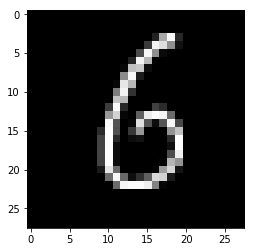

In [6]:
data2 = Numbers2('data/mnist.pklz')
print(data2.train_y[:10])
def view_digit(example, label=None):
    if label is not None: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');
view_digit(data2.train_x[18],data2.train_y[18])

In [46]:
class MultiLogReg:
    """
    Class to store MNIST data for images of 0-9
    """ 
    def __init__(self, X, y, eta = 0.1):
#         self.X = self.normalize_data(X)
        self.X = X
        self.y = self.one_hot_encoding(y)
        self.eta = eta
        self.weights = self.get_optimal_parameters()
        self.confMatrix = np.zeros((10,10), dtype=np.int)
        
    def one_hot_encoding(self, y):
        # TO DO: Represent the output vector y as a one hot encoding. Create a matrix of dimensions (m X 10) 
        # where m = number of examples, and 10 for number of classes
        # if the class for the ith example is 7, then y[i][7] = 1 and the for k != 7, y[i][k] = 0.
        temp = np.zeros((y.shape[0], 10))
        for i in range(len(y)):
            temp[i][y[i]] = 1
        
        return temp
            
        
    def normalize_data(self, X):
        # TO DO: Normalize the dataset X using the mean and standard deviation of all the training examples 
        temp = np.zeros(X.shape)
        for i in range(X.shape[1]):
            temp[:,i] = (X[:,i] - X[:,i].mean()) / X[:,i].std()

        return temp
        
    def get_optimal_parameters(self):
        # TO DO: This is the main training loop. You will have to find the optimal weights for all 10 models
        # Each model is fit to its class which is (0-9), and the cost function will be against all of the other 
        # numbers, i.e. "the rest".
        weights = {}
        for i in range(10):
            log_reg = LogReg(self.X, self.y[:,i])
            weights[i] = log_reg.mini_batch_update(32)
            weights[i] = log_reg.mini_batch_update(32)
            weights[i] = log_reg.mini_batch_update(32)
            
        return weights

    
    def accuracy(self, test_x, test_y):
        length = len(test_y)
        hit = 0
        self.confMatrix = np.zeros((10,10), dtype=np.int)
        for i in range(length):
            probs = self.predict(test_x[i])
            self.confMatrix[int(probs[0][0])][test_y[i]] += 1 
            if int(probs[0][0]) == test_y[i]:
                hit += 1
        
        return hit/len(test_y)
    

    def predict(self, test_image):
        # TO DO: This function should return the probabilities predicted by each of the models for some given 
        # input image. The probabilities are sorted with the most likely being listed first.
        # Return a vector of shape (10, 2) with the first column holding the number and the second column with
        # the probability that the test_image is that number
        probs = np.zeros((10, 2))
        temp = {}
        for i in range(10):
            score = 0
            for j in range(len(test_image)):
                score += float(self.weights[i][j]*test_image[j])
            temp[1 / (1 + math.exp(-score))] = i
            
        keys = sorted(temp.keys())
        keys.reverse()
        index = 0
        for i in keys:
            probs[index] = (temp[i], i)
            index += 1
            
        return probs
    
    def printConfMatrix(self, C):
        t = PrettyTable([""] + [i for i in range(10)])
        for i in range(10):
            row = [i] + list(C[i])
            t.add_row(row)
        print("Predict(row)/Correct(col)")
        print(t)
        


### QUESTION ###
It is important to know how well your model did on the whole. You need to report the ___accuracy as a percentage___ on the training set and the test set from Numbers2. You should also plot a ___confusion matrix___ for both, just like you did on the last homework and mention the numbers that were misclassified the most

In [27]:
numbers2 = Numbers2('data/mnist.pklz')

In [37]:
start_time = time.time()
mult_log_reg = MultiLogReg(numbers2.train_x, numbers2.train_y)
print(time.time() - start_time)

830.9629461765289


In [38]:
print("Training set")
print("Accuracy", mult_log_reg.accuracy(numbers2.train_x, numbers2.train_y))
mult_log_reg.printConfMatrix(mult_log_reg.confMatrix)
print("")
print("Test set")
print("Accuracy", mult_log_reg.accuracy(numbers2.test_x, numbers2.test_y))
mult_log_reg.printConfMatrix(mult_log_reg.confMatrix)

Training set
[[3.00000000e+00 9.92098459e-01]
 [5.00000000e+00 9.82773665e-01]
 [0.00000000e+00 7.43762743e-08]
 [7.00000000e+00 3.71691480e-08]
 [2.00000000e+00 5.74471882e-09]
 [6.00000000e+00 1.16138737e-10]
 [8.00000000e+00 2.38601165e-12]
 [1.00000000e+00 1.96603800e-12]
 [9.00000000e+00 3.23138378e-13]
 [4.00000000e+00 5.75626098e-15]]
3.0 3
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
(10, 10)


IndexError: arrays used as indices must be of integer (or boolean) type